# Data Mining Midterm Project
### Why We Chose This Dataset:
This data set is extremely robust with information that is thought to be linked to health and nutrition. There are extensive subsets such as demographics, diet, exams, labs, and more that can be analyzed to find correlations that contribute positively or negatively to overall health. There are a lot of questions that can be answered with this data set; we will try to focus on a few we think are interesting to us
### Business Questions:
1. Can we identify habits/factors that positively or negatively affect health?
2. Is there a correlation between income level and overall health?
3. Can we identify the main diseases that affect certain demographics?
4. Does the presence of one disease increase the likelihood of the presence of another diease within an individual?
### Project Outline:
1. **Software Engineering** - Will build functions such as `dataLoader(), logger(), featurize(), cluster(),` and `dimRed()` to streamline data transformations within the dataframe(s).
2. **Data Engineering** - Will clean, organize, and transform the data for ease of use during the research and analysis portion of the project. Featurization. 
3. **Business Analysis** - Discover initial challenge questions for the dataset(s). Then evolve the questions as we iterate through the project. 
4. **Research** - After featurization, extract metadata on the full dataset and run clustering/dimentions reduction on various slices of the data. Metadata will be added to each cluster. Each iteration may vary on addition/deletion of features as we attempts to gain a conclusion on our business questions. 
### Resources:
- https://www.kaggle.com/code/tobyanderson/health-survey-analysis
- https://www.kaggle.com/code/gopalkholade/diabetes-prediction
- https://www.kaggle.com/code/sohamohajeri/nhanes-dimensionality-reduction-and-clustering 
- https://www.kaggle.com/code/lcchennn/stroke-prediction-using-machine-learning
- https://www.kaggle.com/code/kaggleaar/diseases-and-medications-analysis

### TODO:
1. Featurize the dataset. Clean, organize, and transform the dataset into a useable format. Drop columns, fix null values, etc
2. Build functions `dataLoader(), logger(), cluster(), dimRed()`
3. Extract metadata, cluster, dimension reduction
4. Generate *great* visuals
5. Attempt to answer business questions. 

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

**Useful Functions**

In [361]:
# Returns table with columns and corresponding null value percentages
def get_nulls(df):
    sum_null = df.isnull().sum()
    df_shape = df.shape[0]
    null = 100 * (sum_null / df_shape)
    return pd.DataFrame({'nullPercent': null})

# Selects colmuns with more than 70% null values and removes them from the df.
def null_handler(df):
    # get percentage of nulls in dataframe.
    df_null = get_nulls(df)
    high = df_null[df_null['nullPercent'] > 70]
    df.drop(list(high.index), axis=1, inplace=True)
    print("Dropped {} columns with more than 70% null values.".format(high.size))
    
# Selects columns with null values and replaces with the mean of each column
def mean_replace_null(df):
    df_null = get_nulls(df)
    df_maj_null = df_null[df_null['nullPercent'] > 0]
    for i in list(df_maj_null.index):
        df[i] = df[i].fillna(df[i].mean())
    print("Replaced {} columns with null values with mean of the column.".format(df_maj_null.size))

# Selects columns with object datatypes and removes them from the df. 
def object_handler(df):
    types = pd.DataFrame({'type': df.dtypes})
    objects = types[types['type'] == 'object']
    df.drop(list(objects.index), axis=1, inplace=True)
    print("Dropped {} columns with object data types".format(objects.size))

# reurns the number of null values in dataset
def check_nulls(df):
    null_list = []
    sum_nulls = 0
    for x in list(df.isnull().sum()):
        if x != 0:
            print(x)
        else:
            null_list.append(x)
    for i in null_list:
        sum_nulls += null_list[i]
    print("Dataframe has {} columns with null values".format(sum_nulls))

    ss = StandardScaler().fit_transform(df)
    ss = pd.DataFrame(ss)
    return ss
   

**Load and Join Data**

In [326]:
demo = pd.read_csv('nhnes/demographic.csv')
diet = pd.read_csv('nhnes/diet.csv')
exam = pd.read_csv('nhnes/examination.csv')
labs = pd.read_csv('nhnes/labs.csv')
meds = pd.read_csv('nhnes/medications.csv', encoding='latin1')

In [327]:
df = pd.concat([demo, diet, exam, labs], axis=1)
df.shape

(10175, 863)

**Data Cleaning**
1. Keeping the columns that are not highly specific, repeated, or encoded in a way that is not meaningful to us
2. Handle nulls
3. Handle objects

In [350]:
col_decoder = {
'ACD011A' : 'speak_english',
'AIALANGA' : 'speak_english2',
'ALQ101' : 'drink_alcohol',
'ALQ130' : 'alcohol_per_day',
'AUQ136' : 'ear_infections',
'BMDAVSAD' : 'saggital_abdominal_avg',
'BMXARMC' : 'arm_circum',
'BMXBMI' : 'BMI',
'BMXLEG' : 'leg_length',
'BMXSAD1' : 'saggital_abdominal_1',
'BMXSAD2' : 'saggital_abdominal_2',
'BMXWAIST' : 'waist_circum',
'BMXWT' : 'weight_kg',
'BPQ020' : 'high_bp',
'BPQ056' : 'measure_bp_home',
'BPQ059' : 'measure_bp_doctor',
'BPQ060' : 'cholesterol_checked',
'BPQ070' : 'cholesterol_checked_1y',
'BPQ080' : 'high_cholesterol',
'BPQ090D' : 'cholesterol_prescription',
'BPXDI1' : 'diastolic_bp',
'BPXML1' : 'cuff_max_inflation',
'BPXSY1' : 'blood_pressure_1',
'BPXSY2' : 'blood_pressure_2',
'BPXSY3' : 'blood_pressure_3',
'CBD070' : 'grocery_budget',
'CBD090' : 'nonfood_budget',
'CBD110' : 'food_budget',
'CBD120' : 'restaurant_budget',
'CBD130' : 'food_delivery_budget',
'CBQ505' : 'fast_food',
'CBQ535' : 'saw_nutrition_fast_food',
'CBQ545' : 'use_nutrition_fast_food',
'CBQ550' : 'eat_restaurants',
'CBQ552' : 'eat_chain_restaurants',
'CBQ580' : 'saw_nutrition_restaurant',
'CBQ590' : 'use_nutrition_restaurant',
'CBQ596' : 'saw_my_plate',
'CDQ001' : 'chest_pain_ever',
'CDQ010' : 'short_breath_stairs',
'CSQ030' : 'sensative_smell',
'CSQ100' : 'loss_of_taste',
'CSQ110' : 'taste_in_mouth',
'CSQ202' : 'dry_mouth',
'CSQ204' : 'nasal_congestion',
'CSQ210' : 'wisdom_teeth_removed',
'CSQ220' : 'tonsils_removed',
'CSQ240' : 'head_injury',
'CSQ250' : 'broken_nose',
'CSQ260' : 'sinus_infections',
'DBD100' : 'salt_frequency',
'DBD895' : 'meals_not_homemade',
'DBD900' : 'meals_fast_food',
'DBD905' : 'meals_prepackaged',
'DBD910' : 'frozen_meals_per_month',
'DBQ095Z' : 'salt_type',
'DBQ197' : 'milk_product_per_month',
'DBQ229' : 'milk_drinker',
'DBQ700' : 'healthy_diet',
'DEQ034C' : 'long_sleeve_shirt',
'DEQ034D' : 'use_sunscreen',
'DEQ038G' : 'sunburn_1y',
'DIQ010' : 'diabetes',
'DIQ050' : 'taking_insulin',
'DIQ160' : 'prediabetes',
'DIQ170' : 'diabetes_risk',
'DIQ172' : 'diabetes_concern',
'DIQ180' : 'blood_test_3y',
'DLQ010' : 'deaf',
'DLQ020' : 'blind',
'DLQ040' : 'mental_issues',
'DLQ050' : 'difficulty_walking',
'DLQ060' : 'difficulty_dressing',
'DLQ080' : 'difficulty_errands',
'DMDBORN4' : 'born_in_us2',
'DMDHHSIZ' : 'people_in_house',
'DMDHHSZB' : 'children_in_house',
'DMDHHSZE' : 'people_over_60_in_house',
'DMDHRBR4' : 'born_in_us',
'DMDHRGND' : 'gender2',
'DMDMARTL' : 'Marital_Status',
'DMDYRSUS' : 'years_in_US',
'DPQ010' : 'no_interest_2w',
'DPQ020' : 'depression',
'DPQ030' : 'trouble_sleeping_2w',
'DPQ040' : 'fatigue_2w',
'DPQ050' : 'eating_problems_2w',
'DPQ060' : 'feel_bad_2w',
'DPQ070' : 'trouble_concentrating_2w',
'DPQ080' : 'speaking_problems_2w',
'DPQ090' : 'suicidal_2w',
'DPQ100' : 'depression_difficulty',
'DR1.320Z' : 'water',
'DR1_320Z' : 'plain_water_yesterday',
'DR1_330Z' : 'tap_water_yesterday',
'DR1BWATZ' : 'bottled_water_yesterday',
'DR1HELPD' : 'interview_help',
'DR1TACAR' : 'dietary_alpha_carotene',
'DR1TALCO' : 'alcohol',
'DR1TATOC' : 'dietary_vitamin_e',
'DR1TBCAR' : 'dietary_beta_carotene',
'DR1TCAFF' : 'caffeine',
'DR1TCALC' : 'dietary_calcium',
'DR1TCARB' : 'carb',
'DR1TCHL' : 'dietary_choline',
'DR1TCHOL' : 'cholesterol',
'DR1TCOPP' : 'dietary_copper',
'DR1TCRYP' : 'dietary_beta_cryptoxanthin',
'DR1TFA' : 'dietary_folic_acid',
'DR1TFF' : 'folate_food',
'DR1TFIBE' : 'fiber',
'DR1TFOLA' : 'dietary_folate',
'DR1TIRON' : 'dietary_iron',
'DR1TKCAL' : 'calories',
'DR1TLYCO' : 'dietary_lycopene',
'DR1TLZ' : 'dietary_lutein',
'DR1TM181' : 'octadecenoic_percent',
'DR1TMAGN' : 'magnesium',
'DR1TMFAT' : 'monounsaturated_fats',
'DR1TMOIS' : 'moisture',
'DR1TNIAC' : 'dietary_niacin',
'DR1TP183' : 'octadecatrienoic_percent',
'DR1TPHOS' : 'dietary_phosphorus',
'DR1TPOTA' : 'dietary_potassium',
'DR1TPROT' : 'protein',
'DR1TRET' : 'dietary_retinol',
'DR1TS140' : 'tetradeconoic_percent',
'DR1TSELE' : 'dietary_selenium',
'DR1TSODI' : 'sodium',
'DR1TSUGR' : 'sugar',
'DR1TTFAT' : 'fat',
'DR1TTHEO' : 'dietary_theobromine',
'DR1TVARA' : 'dietary_vitamin_a',
'DR1TVB1' : 'dietary_b1',
'DR1TVB12' : 'dietary_b12',
'DR1TVB2' : 'dietary_b2',
'DR1TVB6' : 'dietary_b6',
'DR1TVC' : 'dietary_vit_c',
'DR1TVD' : 'dietary_vit_d',
'DR1TVK' : 'dietary_vit_k',
'DR1TZINC' : 'dietary_zinc',
'DRABF' : 'breast_fed',
'DRD340' : 'shellfish',
'DRD350A' : 'clams',
'DRD350B' : 'crabs',
'DRD350C' : 'crayfish',
'DRD350D' : 'lobsters',
'DRD350E' : 'mussels',
'DRD350F' : 'oysters',
'DRD350G' : 'scallops',
'DRD350H' : 'shrimp',
'DRD370A' : 'breaded_fish',
'DRD370B' : 'tuna',
'DRD370C' : 'bass',
'DRD370D' : 'catfish',
'DRD370E' : 'cod',
'DRD370F' : 'flatfish',
'DRD370G' : 'haddock',
'DRD370H' : 'mackerel',
'DRD370I' : 'perch',
'DRD370J' : 'pike',
'DRD370K' : 'pollock',
'DRD370L' : 'porgy',
'DRD370M' : 'salmon',
'DRD370N' : 'sardines',
'DRD370O' : 'sea_bass',
'DRD370P' : 'shark',
'DRD370Q' : 'swordfish',
'DRD370R' : 'trout',
'DRD370S' : 'walleye',
'DRD370T' : 'other_fish',
'DRQSDIET' : 'special_diet',
'DRQSDT1' : 'low_cal_diet',
'DRQSDT10' : 'high_protein_diet',
'DRQSDT11' : 'low_gluten_diet',
'DRQSDT12' : 'kidney_diet',
'DRQSDT2' : 'low_fat_diet',
'DRQSDT3' : 'low_salt_diet',
'DRQSDT4' : 'low_sugar_diet',
'DRQSDT5' : 'low_fiber_diet',
'DRQSDT6' : 'high_fiber_diet',
'DRQSDT7' : 'diabetic_diet',
'DRQSDT8' : 'muscle_diet',
'DRQSDT9' : 'low_carb_diet',
'DRQSDT91' : 'other_diet',
'DRQSPREP' : 'salt_used',
'DUQ200' : 'marijuana',
'DUQ370' : 'needle_drugs',
'FSD032A' : 'food_insecure',
'FSD032B' : 'not_enough_food',
'FSD032C' : 'cheap_food',
'FSD032D' : 'cheap_food_children',
'FSD032E' : 'bad_food_children',
'FSD032F' : 'low_food_children',
'FSD151' : 'emergency_food_received',
'FSDAD' : 'food_secure',
'FSDCH' : 'child_food_secure',
'FSDHH' : 'household_food_secure',
'FSQ162' : 'wic_received',
'FSQ165' : 'food_stamps',
'HEQ010' : 'hepetitis_b',
'HEQ030' : 'hepetitis_c',
'HIQ011' : 'health_insurance',
'HIQ210' : 'insurance_gap',
'HIQ270' : 'prescription_insurance',
'HOD050' : 'rooms_in_home',
'HOQ065' : 'homeowner',
'HSAQUEX' : 'health_status_source_data',
'HSD010' : 'general_health',
'HSQ500' : 'ever_had_cold',
'HSQ510' : 'intestinal_illness',
'HSQ520' : 'ever_had_flu',
'HSQ571' : 'donate_blood',
'HSQ590' : 'hiv',
'HUQ010' : 'general_health2',
'HUQ020' : 'health_compared_last_year',
'HUQ030' : 'routine_healthcare',
'HUQ041' : 'healthcare_location',
'HUQ051' : 'dr_visits',
'HUQ071' : 'overnight_hospital',
'HUQ090' : 'mental_health_treatment',
'IMQ011' : 'hepatitis_a_vaccine',
'IMQ020' : 'hepatitis_b_vaccine',
'IND235' : 'monthly_income',
'INDFMMPC' : 'poverty_level_category',
'INDFMMPI' : 'poverty_level_index',
'INDFMPIR' : 'family_income',
'INQ012' : 'self_employ_income',
'INQ020' : 'income_from_wages',
'INQ030' : 'income_from_SS',
'INQ060' : 'disability_income',
'INQ080' : 'retirement_income',
'INQ090' : 'ss_income',
'INQ132' : 'state_assistance_income',
'INQ140' : 'investment_income',
'INQ150' : 'other_income',
'INQ244' : 'family_savings',
'LBDBCDLC' : 'blood_cadmium',
'LBDBGMLC' : 'methyl_mercury',
'LBDHDD' : 'HDL_mg',
'LBDIHGLC' : 'inorganic_mercury',
'LBDNENO' : 'neutrophils_percent',
'LBDTHGLC' : 'blood_mercury',
'LBDWFL' : 'floride_water',
'LBXEOPCT' : 'eosinophils_percent',
'LBXGH' : 'glyco_hemoglobin',
'LBXLYPCT' : 'lymphocite_percent',
'LBXMC' : 'hemoglobin_concentration',
'LBXSAL' : 'blood_albumin',
'LBXSCA' : 'blood_calcium',
'LBXSGL' : 'serum_glucose_mg',
'LBXSTP' : 'blood_protein',
'MCQ010' : 'asthma_ever',
'MCQ025' : 'asthma_age',
'MCQ035' : 'asthma',
'MCQ040' : 'asthma_year',
'MCQ050' : 'asthma_ER',
'MCQ053' : 'anemia',
'MCQ070' : 'psoriasis',
'MCQ080' : 'overweight',
'MCQ082' : 'celiac_disease',
'MCQ086' : 'gluten_free',
'MCQ092' : 'blood_transfusion',
'MCQ149' : 'menstruate',
'MCQ151' : 'menstruate_age',
'MCQ160A' : 'arthritis',
'MCQ160B' : 'congestive_heart_failure',
'MCQ160C' : 'coronary_heart_disease',
'MCQ160D' : 'angina',
'MCQ160E' : 'heart_attack',
'MCQ160F' : 'stroke',
'MCQ160G' : 'emphysema',
'MCQ160K' : 'bronchitis_ever',
'MCQ160L' : 'liver_condition_ever',
'MCQ160M' : 'thyroid_ever',
'MCQ160N' : 'gout',
'MCQ160O' : 'COPD',
'MCQ170K' : 'bronchitis_now',
'MCQ170L' : 'liver_condition',
'MCQ170M' : 'thyroid_now',
'MCQ180A' : 'arthritis_age',
'MCQ180B' : 'heart_failure_age',
'MCQ180C' : 'heart_disease_age',
'MCQ180D' : 'angina_age',
'MCQ180E' : 'heart_attack_age',
'MCQ180F' : 'stroke_age',
'MCQ180G' : 'emphysema_age',
'MCQ180K' : 'bronchitis_age',
'MCQ180L' : 'liver_condition_age',
'MCQ180M' : 'thyroid_age',
'MCQ180N' : 'gout_age',
'MCQ195' : 'arthritis_type',
'MCQ203' : 'jaundice',
'MCQ206' : 'jaundice_age',
'MCQ220' : 'cancer',
'MCQ230A' : 'cancer_type1',
'MCQ230B' : 'cancer_type2',
'MCQ230C' : 'cancer_type3',
'MCQ230D' : 'cancer_type4',
'MCQ240A' : 'bladder_cancer_age',
'MCQ240AA' : 'test_cancer_age',
'MCQ240B' : 'blood_cancer_age',
'MCQ240BB' : 'thyroid_cancer_age',
'MCQ240C' : 'bone_cancer_age',
'MCQ240CC' : 'uterine_cancer_age',
'MCQ240D' : 'brain_cancer_age',
'MCQ240DK' : 'cancer_age',
'MCQ240E' : 'breast_cancer_age',
'MCQ240F' : 'cervical_cancer_age',
'MCQ240G' : 'colon_cancer_age',
'MCQ240H' : 'esoph_cancer_age',
'MCQ240I' : 'gallbladder_cancer_age',
'MCQ240J' : 'kidney_cancer_age',
'MCQ240K' : 'larynx_cancer_age',
'MCQ240L' : 'leukemia_age',
'MCQ240M' : 'liver_cancer_age',
'MCQ240N' : 'lung_cancer_age',
'MCQ240O' : 'lymphoma_age',
'MCQ240P' : 'melanoma_age',
'MCQ240Q' : 'mouth_cancer_age',
'MCQ240R' : 'nervous_cancer_age',
'MCQ240S' : 'ovarian_cancer_age',
'MCQ240T' : 'pancreatic_cancer_age',
'MCQ240U' : 'prostate_cancer_age',
'MCQ240V' : 'rectal_cancer_age',
'MCQ240X' : 'skin_cancer_age',
'MCQ240Y' : 'soft_cancer_age',
'MCQ240Z' : 'stomach_cancer_age',
'MCQ300A' : 'relative_heart_attack',
'MCQ300B' : 'relative_asthma',
'MCQ300C' : 'relative_diabetes',
'MCQ365A' : 'need_weight_loss',
'MCQ365B' : 'need_exercise',
'MCQ365C' : 'need_reduce_salt',
'MCQ365D' : 'need_reduce_calories',
'MCQ370A' : 'losing_weight',
'MCQ370B' : 'excercising',
'MCQ370C' : 'reducing_salt',
'MCQ370D' : 'reducing_fat',
'MGDCGSZ' : 'grip_strength',
'OCD150' : 'work_done',
'OCD270' : 'months_of_work',
'OCD390G' : 'type_of_work',
'OCD395' : 'job_duration',
'OCQ260' : 'non_govt_employee',
'OHQ030' : 'visit_dentist',
'OHQ033' : 'dentist_reason',
'OHQ620' : 'aching_mouth',
'OHQ640' : 'mouth_problems',
'OHQ680' : 'mouth_problems2',
'OHQ770' : 'need_dental',
'OHQ835' : 'gum_disease',
'OHQ845' : 'teeth_health',
'OHQ850' : 'gum_treatment',
'OHQ855' : 'loose_teeth',
'OHQ860' : 'teeth_bone_loss',
'OHQ865' : 'weird_tooth',
'OHQ870' : 'floss',
'OHQ875' : 'use_mouthwash',
'OHQ880' : 'oral_cancer_exam',
'OHQ885' : 'oral_cancer_exam2',
'OSQ060' : 'osteoporosis',
'OSQ130' : 'take_prednisone',
'OSQ230' : 'metal_objects',
'PAAQUEX' : 'question_source',
'PAD680' : 'sedentary_time',
'PAQ605' : 'vigorous_work',
'PAQ620' : 'moderate_work',
'PAQ635' : 'walk_or_bike',
'PAQ650' : 'vigorous_recreation',
'PAQ665' : 'moderate_recreation',
'PAQ710' : 'tv_hours',
'PAQ715' : 'pc_hours',
'PEASCST1' : 'bp_status',
'PEASCTM1' : 'blood_pressure_time',
'PFQ049' : 'work_limitations',
'PFQ051' : 'work_limitations2',
'PFQ054' : 'walk_equipment_required',
'PFQ057' : 'confusion_memory_problems',
'PFQ090' : 'special_healthcare_equipment',
'PUQ100' : 'insecticide_used',
'PUQ110' : 'weedkiller_used',
'RIAGENDR' : 'gender',
'RIDAGEYR' : 'age',
'RIDRETH1' : 'hispanic',
'RXQ510' : 'take_aspirin',
'SLD010H' : 'sleep_hours',
'SLQ050' : 'trouble_sleeping',
'SLQ060' : 'sleep_disorder',
'SMAQUEX.x' : 'question_mode',
'SMAQUEX.y' : 'question_mode2',
'SMAQUEX2' : 'question_mode3',
'SMD460' : 'smokers_in_house',
'SMDANY' : 'tobaco_1w',
'SMQ681' : 'smoked_1w',
'SMQ851' : 'tobaco2_1w',
'SMQ856' : 'smoked_at_work',
'SMQ858' : 'someone_smoked_at_job',
'SMQ860' : 'smoked_at_restaurant',
'SMQ863' : 'nicotine_1w',
'SMQ866' : 'smoked_at_bar',
'SMQ870' : 'smoked_in_car',
'SMQ872' : 'someone_smoked_in_car',
'SMQ874' : 'smoked_another_home',
'SMQ876' : 'someone_smoked_in_home',
'SMQ878' : 'smoked_other_building',
'SMQ880' : 'someone_smoked_other_building',
'SXD021' : 'sex_ever',
'URXUCR' : 'creatinine_urine',
'WHD010' : 'height_in',
'WHD020' : 'current_weight_lb',
'WHD050' : 'weight_1y',
'WHD110' : 'weight_10y',
'WHD120' : 'weight_age_25',
'WHD140' : 'greatest_weight',
'WHQ030' : 'overweight_self',
'WHQ040' : 'weightloss_desire',
'WHQ070' : 'weightloss_attempt',
'WHQ150' : 'age_when_heaviest'
}
df = df.rename(columns = col_decoder)
keep_cols = list(col_decoder.values())
df = df[df.columns.intersection(keep_cols)]
df

,gender,age,hispanic,born_in_us2,Marital_Status,speak_english2,people_in_house,children_in_house,people_over_60_in_house,gender2,...,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,floride_water,HDL_mg,glyco_hemoglobin,inorganic_mercury,methyl_mercury,blood_cadmium,blood_mercury
0,1,69,4,1,4.00000,1.000000,3,0,2,1,...,3.40000,2.000000,33.40000,0.561246,65.000000,13.900000,0.826087,0.255072,0.289933,0.256759
1,1,54,3,1,1.00000,1.000000,4,2,0,1,...,6.10000,7.400000,32.50000,0.561246,50.000000,9.100000,1.000000,0.000000,0.000000,0.000000
2,1,72,3,1,1.00000,1.099414,2,0,2,1,...,5.60000,4.900000,34.30000,0.561246,60.000000,8.900000,0.000000,0.000000,0.000000,0.000000
3,1,9,3,1,2.57185,1.000000,4,2,0,1,...,1.70000,4.600000,34.00000,1.230000,61.000000,5.642556,0.000000,0.000000,1.000000,0.000000
4,2,73,3,1,1.00000,1.099414,2,0,2,1,...,2.40000,4.500000,33.00000,0.561246,85.000000,4.900000,0.826087,0.255072,0.289933,0.256759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,1,26,2,1,5.00000,1.000000,5,0,0,2,...,2.98771,4.094788,33.80989,0.561246,53.105194,5.642556,0.826087,0.255072,0.289933,0.256759
10171,2,2,1,1,2.57185,1.099414,4,1,0,1,...,2.98771,4.094788,33.80989,0.561246,53.105194,5.642556,0.826087,0.255072,0.289933,0.256759
10172,2,42,4,2,3.00000,1.099414,1,0,0,2,...,2.98771,4.094788,33.80989,0.561246,53.105194,5.642556,0.826087,0.255072,0.289933,0.256759
10173,1,7,2,1,2.57185,1.099414,4,1,0,2,...,2.98771,4.094788,33.80989,0.561246,53.105194,5.642556,0.826087,0.255072,0.289933,0.256759


*These functions were useful before we decided to drop excessive columns*

In [351]:
null_handler(df)
df.shape

Dropped 0 columns with more than 70% null values.


(10175, 124)

In [352]:
object_handler(df)
df.shape

Dropped 0 columns with object data types


(10175, 124)

In [353]:
mean_replace_null(df)

Replaced 0 columns with null values with mean of the column.


In [354]:
check_nulls(df)

Dataframe has 0 columns with null values


**Dimensionality Reduction by PCA Discovery**

*Why?* The cleaned dataset has 671 columns, or 671 dimensions or input features. The rows of data therefore only represent a small and non-representative sample. We want to try to reduce the number of dimensions while keeping as much variation in the original dataset as possible.


In [368]:
ss = StandardScaler()
X = ss.fit_transform(df)
dfx = pd.DataFrame(data=X, columns=df.columns[0:])
dfx.head()


,gender,age,hispanic,born_in_us2,Marital_Status,speak_english2,people_in_house,children_in_house,people_over_60_in_house,gender2,...,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,floride_water,HDL_mg,glyco_hemoglobin,inorganic_mercury,methyl_mercury,blood_cadmium,blood_mercury
0,-1.016750,1.536248,0.718871,-0.124028,7.222447e-01,-0.375931,-0.507923,-0.845262,2.275361,-0.999902,...,0.184658,-1.284024,-0.432126,0.000000,0.902273,1.017097e+01,4.107176e-16,0.000000,-1.708920e-16,1.774976e-16
1,-1.016750,0.922009,-0.072743,-0.124028,-7.949163e-01,-0.375931,0.072764,0.831257,-0.562739,-0.999902,...,1.393944,2.025968,-1.380951,0.000000,-0.235542,4.258649e+00,6.433765e-01,-0.820516,-8.925634e-01,-8.209911e-01
2,-1.016750,1.659096,-0.072743,-0.124028,-7.949163e-01,0.000000,-1.088609,-0.845262,2.275361,-0.999902,...,1.170002,0.493564,0.516698,0.000000,0.523001,4.012302e+00,-3.056039e+00,-0.820516,-8.925634e-01,-8.209911e-01
3,-1.016750,-0.920709,-0.072743,-0.124028,-4.491699e-16,-0.375931,0.072764,0.831257,-0.562739,-0.999902,...,-0.576744,0.309675,0.200423,2.946157,0.598855,1.093999e-15,-3.056039e+00,-0.820516,2.185954e+00,-8.209911e-01
4,0.983526,1.700045,-0.072743,-0.124028,-7.949163e-01,0.000000,-1.088609,-0.845262,2.275361,-0.999902,...,-0.263226,0.248379,-0.853826,0.000000,2.419359,-9.146310e-01,4.107176e-16,0.000000,-1.708920e-16,1.774976e-16


In [370]:
dfx.describe()

,gender,age,hispanic,born_in_us2,Marital_Status,speak_english2,people_in_house,children_in_house,people_over_60_in_house,gender2,...,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,floride_water,HDL_mg,glyco_hemoglobin,inorganic_mercury,methyl_mercury,blood_cadmium,blood_mercury
count,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,...,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04,1.017500e+04
mean,-8.519530e-17,5.237416e-17,5.167584e-17,5.272332e-17,-4.783506e-16,5.481828e-17,4.434345e-17,-4.888255e-17,-7.821208e-17,-6.005570e-17,...,7.873582e-17,2.077508e-17,8.057066e-15,-6.948305e-17,-4.392446e-16,8.170369e-16,4.245798e-16,4.312139e-17,-1.955302e-16,1.270946e-16
std,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,...,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,-1.016750e+00,-1.289252e+00,-1.655970e+00,-1.240284e-01,-7.949163e-01,-3.759307e-01,-1.669296e+00,-8.452623e-01,-5.627388e-01,-9.999017e-01,...,-1.338147e+00,-2.264763e+00,-6.125073e+00,-2.428485e+00,-3.269716e+00,-2.639058e+00,-3.056039e+00,-8.205155e-01,-8.925634e-01,-8.209911e-01
25%,-1.016750e+00,-8.797597e-01,-8.643564e-01,-1.240284e-01,-7.949163e-01,-3.759307e-01,-1.088609e+00,-8.452623e-01,-5.627388e-01,-9.999017e-01,...,-5.767443e-01,-6.097668e-01,-4.321263e-01,0.000000e+00,-6.148142e-01,-4.219377e-01,4.107176e-16,-8.205155e-01,-8.925634e-01,-8.209911e-01
50%,9.835263e-01,-2.245711e-01,-7.274287e-02,-1.240284e-01,-4.491699e-16,-3.759307e-01,7.276418e-02,-7.002661e-03,-5.627388e-01,-9.999017e-01,...,-8.407218e-02,0.000000e+00,7.490893e-15,0.000000e+00,-5.389775e-16,1.093999e-15,4.107176e-16,0.000000e+00,-1.708920e-16,1.774976e-16
75%,9.835263e-01,8.401103e-01,7.188707e-01,-1.240284e-01,-4.491699e-16,0.000000e+00,6.534509e-01,8.312570e-01,8.563113e-01,1.000098e+00,...,1.846581e-01,3.709716e-01,5.166982e-01,0.000000e+00,2.954379e-01,1.093999e-15,6.433765e-01,0.000000e+00,-1.708920e-16,1.774976e-16
max,9.835263e-01,1.986690e+00,1.510484e+00,5.341492e+01,4.876568e+01,7.186981e+00,1.814824e+00,2.507776e+00,3.694412e+00,1.000098e+00,...,1.505440e+01,1.318187e+01,3.773170e+01,2.977531e+01,9.094541e+00,1.460521e+01,6.433765e-01,2.396278e+00,2.185954e+00,2.376521e+00


In [371]:
pca = PCA(n_components=None)
dfx_pca = pca.fit(dfx)

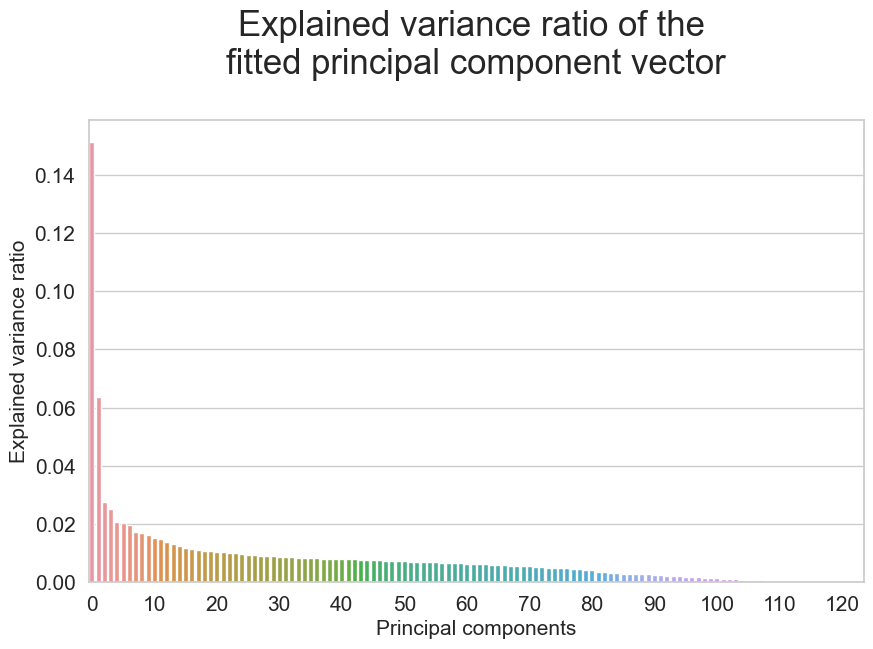

In [386]:
sns.set(style='whitegrid')
sns.set_color_codes('muted')

length = len(dfx_pca.explained_variance_ratio_)

x_vals = [i for i in range(length)]
y_vals = pca.explained_variance_ratio_
x_ticks = [i for i in range(0, len(dfx_pca.explained_variance_ratio_), 10)]

plt.figure(figsize=(10, 6))
sns.barplot(x=x_vals,y=y_vals)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks(x_ticks,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()


As we can see here, the variance drop is at n=3 components. The 1st component explains about 14% of the total variance in the data, and the 2nd explains 6%. These two components can explain 20% of the total variance. This isn't significant, but lets see if we can get better class separation using those components...

https://machinelearningmastery.com/principal-component-analysis-for-visualization/